# Proyecto Máquinas de Aprendizaje
## Predicción de Incendios Forestales utilizando técnicas de Máquinas de Aprendizaje
### Daniel San Martín

Este proyecto tiene como objetivo analizar el trabajo desarrollado en el artículo "**A Data Mining Approach to Predict Forest Fires using Meteorological Data**" de Paulo Cortez y Aníbal Morais. Para esto se realiza una comparación, análisis y propuesta de modelos sobre el trabajo desarrollado por los autores mencionados.

In [1]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data manipulation

# Models
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# Tools 
from sklearn.preprocessing import StandardScaler # data pre-processing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # tools
import matplotlib.pyplot as plt # plots

## Pre-procesamiento de datos

Los datos utilizados en este trabajo fueron extraidos del parque natural de Montesinho, en Trás-os-Montes región del noreste de Portugal, y contienen información sobre las áreas de terreno quemada en episodios de incendios entre enero del 2000 y diciembre del 2003.

In [2]:
# Load data
df = pd.read_csv("./data/forestfires.csv", sep = ",",header = 0)

# Categorize month and days
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

# Data information
print("Shape: ", df.shape)
df.info()
df.describe()

Shape:  (517, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null int64
day      517 non-null int64
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(5)
memory usage: 52.6 KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


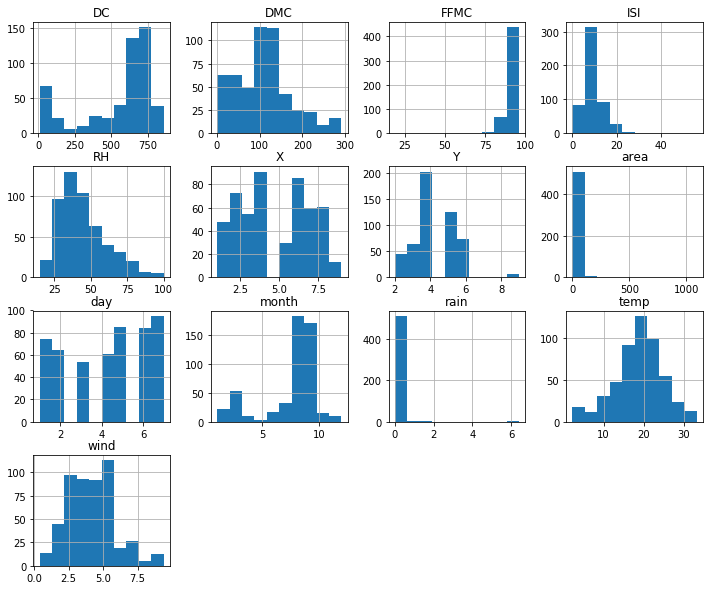

In [3]:
df.hist(figsize=(12, 10))
plt.show()

Notamos que el conjunto de datos posee un total de **517** registros con **12** atributos más la variable dependiente, en este caso el área quemada. Los datos contenidos corresponden a: 
1. Datos espaciales: mapeo del terreno a coordenadas $x$ e $y$.
* Datos temporales: día y mes del año.
* Datos del sistema FWI: códigos asociados al material y cantidad de combustible, además de un índice para evaluar la velocidad del fuego.
* Datos meteorológicos: temperatura (°C), humedad relativa (%), velocidad del viento (km/hr) y precipitaciones en (mm/m²).

El área, la variable dependiente, se encuentra expresada en hectáreas (ha).

Además, los autores proponene 4 configuraciones de características para desarrollar los modelos:
1. **STFWI** utilizando los datos espaciales, temporales y FWI.
* **STM** utilizando los datos espaciales, temporales y meteorológicos.
* **FWI**  utilizando solo los datos de este sistema.
* **M** utilizando los datos meteorológicos.

A modo de comparación, se utilizarán de igual forma los datos "crudos".  Para mejorar la capacidad del modelo se utiliza la categorización utilizando la estrategia *1-of-C*.


In [4]:
# Data configurations
STFWI = df.loc[:, ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI']]
STFWI = pd.get_dummies(STFWI, columns=['month', 'day'])
STM = df.loc[:, ['X', 'Y', 'month', 'day', 'temp', 'RH', 'wind', 'rain']]
STM = pd.get_dummies(STM, columns=['month', 'day'])
FWI = df.loc[:, ['FFMC', 'DMC', 'DC', 'ISI']]
M = df.loc[:, ['temp', 'RH', 'wind', 'rain']]

# "raw data" X and Y separation
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [5]:
# Train and test split for all data configurations
ts, rs = 0, 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
STFWI_train, STFWI_test, _, _ = train_test_split(STFWI, y, test_size=ts, random_state=rs)
STM_train, STM_test, _, _ = train_test_split(STM, y, test_size=ts, random_state=rs)
FWI_train, FWI_test, _, _ = train_test_split(FWI, y, test_size=ts, random_state=rs)
M_train, M_test, _, _ = train_test_split(M, y, test_size=ts, random_state=rs)

In [6]:
# Scalers
s1 = StandardScaler().fit(X_train)
s2 = StandardScaler().fit(STFWI_train)
s3 = StandardScaler().fit(STM_train)
s4 = StandardScaler().fit(FWI_train)
s5 = StandardScaler().fit(M_train)

# Pre-processing for all configurations 
X_train_sc = pd.DataFrame(s1.transform(X_train), columns=X_train.columns)
X_train_sc.insert(X_train_sc.shape[1], 'intercept', np.ones(X_train_sc.shape[0]))
STFWI_train_sc = pd.DataFrame(s2.transform(STFWI_train), columns=STFWI_train.columns)
STFWI_train_sc.insert(STFWI_train_sc.shape[1], 'intercept', np.ones(STFWI_train_sc.shape[0]))
STM_train_sc = pd.DataFrame(s3.transform(STM_train), columns=STM_train.columns)
STM_train_sc.insert(STM_train_sc.shape[1], 'intercept', np.ones(STM_train_sc.shape[0]))
FWI_train_sc = pd.DataFrame(s4.transform(FWI_train), columns=FWI_train.columns)
FWI_train_sc.insert(FWI_train_sc.shape[1], 'intercept', np.ones(FWI_train_sc.shape[0]))
M_train_sc = pd.DataFrame(s5.transform(M_train), columns=M_train.columns)
M_train_sc.insert(M_train_sc.shape[1], 'intercept', np.ones(M_train_sc.shape[0]))

Del análisis realizado anteriormente notamos que existe mayor cantidad de incendios "pequeños", es por esto que se sugiere aplicar la transformación logarítmica $y=ln(x+1)$ para incluir un poco de simetría y además escalar considerablemente los datos.

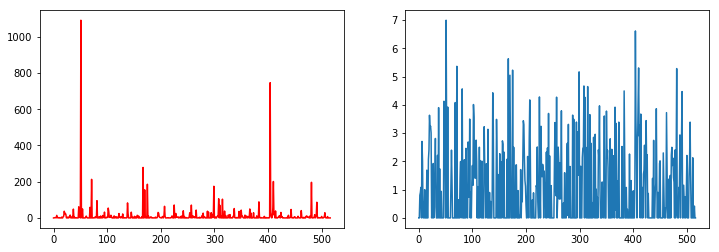

In [7]:
# Logarithmic transform
y_train_sc = np.log(y_train + 1)

# Comparison plot
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(y_train)), y_train, 'r')
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(y_train_sc)), y_train_sc)
plt.show()

Notamos la clara diferencia en el área una vez que aplicamos la transformación logaritmica.

Para evaluar la calidad de los modelos se utilizaran las méticas: R², MAE y MSE

In [8]:
def printScores(y_real, y_hat):
    print("R²: ", r2_score(y_real, y_hat))
    print("MSE: ", mean_squared_error(y_real, y_hat))
    print("RMSE: ", np.sqrt(mean_squared_error(y_real, y_hat)))
    print("MAE: ", mean_absolute_error(y_real, y_hat))

In [71]:
def CVScores(model):
    scores = [
        ["Train R²: ", model.cv_results_['mean_train_r2'][model.best_index_]],
        ["Train MSE: ", model.cv_results_['mean_train_neg_mean_squared_error'][model.best_index_]],
        ["Train MAE: ", model.cv_results_['mean_train_neg_mean_absolute_error'][model.best_index_]],
        ["Test R²: ", model.cv_results_['mean_test_r2'][model.best_index_]],
        ["Test MSE: ", model.cv_results_['mean_test_neg_mean_squared_error'][model.best_index_]],
        ["Test MAE: ", model.cv_results_['mean_test_neg_mean_absolute_error'][model.best_index_]]
    ]
    return pd.DataFrame(scores, columns=['Metric', 'Score'])

## Linear Regression

In [9]:
# Linear Regression raw data
lm1 = LinearRegression(fit_intercept=False, n_jobs=-1)
_ = lm1.fit(X_train_sc, y_train_sc)
y_hat_lm1 = lm1.predict(X_train_sc)
printScores(y_train_sc, y_hat_lm1)

R²:  0.0378289818614
MSE:  1.87800434776
RMSE:  1.37040298736
MAE:  1.12448063862


In [10]:
lm = LinearRegression(fit_intercept=False)
cv_ = 5

In [11]:
# STFWI data
stfwi_mse = cross_val_score(lm, STFWI_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
stfwi_mae = cross_val_score(lm, STFWI_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
stfwi_r2 = cross_val_score(lm, STFWI_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("STFWI")
print("MSE: ", stfwi_mse.mean())
print("MAE: ", stfwi_mae.mean())
print("R2: ", stfwi_r2.mean())

STFWI
MSE:  -2.01567589884
MAE:  -1.15697306456
R2:  -0.0380592056256


In [12]:
# STM data
stm_mse = cross_val_score(lm, STM_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
stm_mae = cross_val_score(lm, STM_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
stm_r2 = cross_val_score(lm, STM_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("STM")
print("MSE: ", stm_mse.mean())
print("MAE: ", stm_mae.mean())
print("R2: ", stm_r2.mean())

STM
MSE:  -1.08356421922e+24
MAE:  -45869469070.0
R2:  -7.41143225089e+23


In [13]:
# FWI data
fwi_mse = cross_val_score(lm, FWI_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
fwi_mae = cross_val_score(lm, FWI_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
fwi_r2 = cross_val_score(lm, FWI_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("FWI")
print("MSE: ", fwi_mse.mean())
print("MAE: ", fwi_mae.mean())
print("R2: ", fwi_r2.mean())

FWI
MSE:  -1.96202425494
MAE:  -1.15841068999
R2:  -0.00914864900879


In [14]:
# M data
m_mse = cross_val_score(lm, M_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
m_mae = cross_val_score(lm, M_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
m_r2 = cross_val_score(lm, M_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("M")
print("MSE: ", m_mse.mean())
print("MAE: ", m_mae.mean())
print("R2: ", m_r2.mean())

M
MSE:  -2.03919610473
MAE:  -1.17161723174
R2:  -0.0513582465201


In [15]:
# Raw data
all_mse = cross_val_score(lm, X_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
all_mae = cross_val_score(lm, X_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
all_r2 = cross_val_score(lm, X_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("Raw")
print("MSE: ", all_mse.mean())
print("MAE: ", all_mae.mean())
print("R2: ", all_r2.mean())

Raw
MSE:  -2.03729582603
MAE:  -1.15510832736
R2:  -0.0514665501873


Numero optimo de features : 1
Scores:  [-0.00464205 -0.0343141  -0.03254584 -0.0546902  -0.05389904 -0.05229652
 -0.04718327 -0.0436979  -0.04201209 -0.04651269 -0.05046844 -0.05047698
 -0.05146655]
Ranking:  [ 5 13  2 12 10  4  3  8  9  7  6 11  1]


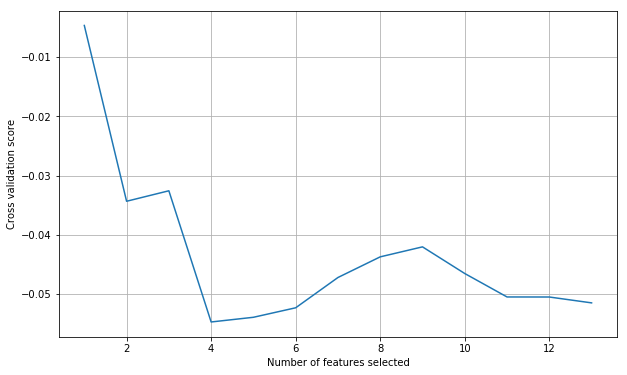

In [16]:
from sklearn.feature_selection import RFECV
lm = LinearRegression(fit_intercept=False, n_jobs=-1)
selector = RFECV(lm, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)

print("Numero optimo de features : %d" % selector.n_features_)
print("Scores: ", selector.grid_scores_) # Puntaje de ajuste
print("Ranking: ", selector.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
plt.grid(True)
plt.show()

## SVM

In [17]:
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001]}
parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_ = 5

In [18]:
# SVR with STFWI data
stfwi_svr = GridSearchCV(SVR(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = stfwi_svr.fit(STFWI_train_sc, y_train_sc)
print("Best parameters: ", stfwi_svr.best_params_)

Best parameters:  {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [19]:
print("STFWI")
print("R²: ", stfwi_svr.cv_results_['mean_test_r2'][stfwi_svr.best_index_])
print("MSE: ", stfwi_svr.cv_results_['mean_test_neg_mean_squared_error'][stfwi_svr.best_index_])
print("MAE: ", stfwi_svr.cv_results_['mean_test_neg_mean_absolute_error'][stfwi_svr.best_index_])

STFWI
R²:  -0.181621391007
MSE:  -2.29854235812
MAE:  -1.0941565026


In [20]:
# SVR with STM data
stm_svr = GridSearchCV(SVR(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = stm_svr.fit(STM_train_sc, y_train_sc)
print("Best parameters: ", stm_svr.best_params_)

Best parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [21]:
print("STM")
print("R²: ", stm_svr.cv_results_['mean_test_r2'][stm_svr.best_index_])
print("MSE: ", stm_svr.cv_results_['mean_test_neg_mean_squared_error'][stm_svr.best_index_])
print("MAE: ", stm_svr.cv_results_['mean_test_neg_mean_absolute_error'][stm_svr.best_index_])

STM
R²:  -0.185288994809
MSE:  -2.30027777928
MAE:  -1.09960610322


In [22]:
# SVR with FWI data
fwi_svr = GridSearchCV(SVR(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = fwi_svr.fit(FWI_train_sc, y_train_sc)
print("Best parameters: ", fwi_svr.best_params_)

Best parameters:  {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [23]:
print("FWI")
print("R²: ", fwi_svr.cv_results_['mean_test_r2'][fwi_svr.best_index_])
print("MSE: ", fwi_svr.cv_results_['mean_test_neg_mean_squared_error'][fwi_svr.best_index_])
print("MAE: ", fwi_svr.cv_results_['mean_test_neg_mean_absolute_error'][fwi_svr.best_index_])

FWI
R²:  -0.21393714328
MSE:  -2.35797390882
MAE:  -1.09257492905


In [24]:
# SVR with M data
m_svr = GridSearchCV(SVR(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = m_svr.fit(M_train_sc, y_train_sc)
print("Best parameters: ", m_svr.best_params_)

Best parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [25]:
print("M")
print("R²: ", m_svr.cv_results_['mean_test_r2'][m_svr.best_index_])
print("MSE: ", m_svr.cv_results_['mean_test_neg_mean_squared_error'][m_svr.best_index_])
print("MAE: ", m_svr.cv_results_['mean_test_neg_mean_absolute_error'][m_svr.best_index_])

M
R²:  -0.218638754124
MSE:  -2.37457017324
MAE:  -1.09193444668


In [26]:
# SVR with all data
all_svr = GridSearchCV(SVR(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = all_svr.fit(X_train_sc, y_train_sc)
print("Best parameters: ", all_svr.best_params_)

Best parameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [27]:
print("All data")
print("R²: ", all_svr.cv_results_['mean_test_r2'][all_svr.best_index_])
print("MSE: ", all_svr.cv_results_['mean_test_neg_mean_squared_error'][all_svr.best_index_])
print("MAE: ", all_svr.cv_results_['mean_test_neg_mean_absolute_error'][all_svr.best_index_])

All data
R²:  -0.161344117525
MSE:  -2.25741455191
MAE:  -1.08911816312


## Decision Trees

In [57]:
parameters = {'criterion': ('mse', 'mae'), 'splitter': ('best', 'random'), 'max_depth': [10, 50, 100]}
scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_ = 5

### STFWI data

In [58]:
stfwi_dt = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = stfwi_dt.fit(STFWI_train_sc, y_train_sc)
print("Best parameters: ", stfwi_dt.best_params_)

Best parameters:  {'criterion': 'mse', 'max_depth': 10, 'splitter': 'random'}


In [75]:
CVScores(stfwi_dt)

,Metric,Score
0,Train R²:,0.530954
1,Train MSE:,-0.916417
2,Train MAE:,-0.622789
3,Test R²:,-0.542088
4,Test MSE:,-2.980349
5,Test MAE:,-1.270283


### STM data

In [76]:
stm_dt = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = stm_dt.fit(STM_train_sc, y_train_sc)
print("Best parameters: ", stm_dt.best_params_)

Best parameters:  {'criterion': 'mse', 'max_depth': 10, 'splitter': 'random'}


In [77]:
CVScores(stm_dt)

,Metric,Score
0,Train R²:,0.518769
1,Train MSE:,-0.936106
2,Train MAE:,-0.637580
3,Test R²:,-0.528792
4,Test MSE:,-2.893472
5,Test MAE:,-1.278925


### FWI data

In [82]:
fwi_dt = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = fwi_dt.fit(FWI_train_sc, y_train_sc)
print("Best parameters: ", fwi_dt.best_params_)

Best parameters:  {'criterion': 'mse', 'max_depth': 10, 'splitter': 'random'}


In [83]:
CVScores(fwi_dt)

,Metric,Score
0,Train R²:,0.307222
1,Train MSE:,-1.357001
2,Train MAE:,-0.830776
3,Test R²:,-0.357600
4,Test MSE:,-2.643077
5,Test MAE:,-1.241780


### M data

In [84]:
m_dt = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = m_dt.fit(M_train_sc, y_train_sc)
print("Best parameters: ", m_dt.best_params_)

Best parameters:  {'criterion': 'mse', 'max_depth': 10, 'splitter': 'best'}


In [85]:
CVScores(m_dt)

,Metric,Score
0,Train R²:,0.502179
1,Train MSE:,-0.971410
2,Train MAE:,-0.654116
3,Test R²:,-0.458636
4,Test MSE:,-2.778987
5,Test MAE:,-1.234688


### All data

In [80]:
all_dt = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = all_dt.fit(X_train_sc, y_train_sc)
print("Best parameters: ", all_dt.best_params_)

Best parameters:  {'criterion': 'mse', 'max_depth': 10, 'splitter': 'random'}


In [81]:
CVScores(all_dt)

,Metric,Score
0,Train R²:,0.598247
1,Train MSE:,-0.779651
2,Train MAE:,-0.545008
3,Test R²:,-0.624932
4,Test MSE:,-3.134150
5,Test MAE:,-1.302183


## Random Forest

In [93]:
parameters = {'n_estimators':[10, 20, 30], 'criterion': ('mse', 'mae'), 'max_depth': [50, 100]}
scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_ = 5

### STFWI data

In [94]:
stfwi_rf = GridSearchCV(RandomForestRegressor(n_jobs=-1), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = stfwi_rf.fit(STFWI_train_sc, y_train_sc)
print("Best parameters: ", stfwi_rf.best_params_)

Best parameters:  {'criterion': 'mae', 'max_depth': 100, 'n_estimators': 20}


In [95]:
CVScores(stfwi_rf)

,Metric,Score
0,Train R²:,0.735463
1,Train MSE:,-0.516893
2,Train MAE:,-0.520372
3,Test R²:,-0.125330
4,Test MSE:,-2.185709
5,Test MAE:,-1.152429


### STM data

In [97]:
all_rf = GridSearchCV(RandomForestRegressor(n_jobs=-1), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = all_rf.fit(X_train_sc, y_train_sc)
print("Best parameters: ", all_rf.best_params_)

Best parameters:  {'criterion': 'mse', 'max_depth': 100, 'n_estimators': 30}


In [98]:
CVScores(all_rf)

,Metric,Score
0,Train R²:,0.828729
1,Train MSE:,-0.334529
2,Train MAE:,-0.450738
3,Test R²:,-0.105836
4,Test MSE:,-2.133634
5,Test MAE:,-1.172027


## Neural Network

In [113]:
parameters = {
    'hidden_layer_sizes': ((10, ), (20, ), (10, 10)), 
    'activation':  ('identity', 'logistic', 'tanh', 'relu') ,
    'solver': ('lbfgs', 'sgd', 'adam'),
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [50, 100, 200],
    'learning_rate': ('constant', 'invscaling', 'adaptive')
}
scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_ = 5

In [116]:
import warnings
warnings.filterwarnings('ignore')

all_mlp = GridSearchCV(MLPRegressor(), parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=4)
_ = all_mlp.fit(X_train_sc, y_train_sc)
print("Best parameters: ", all_mlp.best_params_)

Best parameters:  {'activation': 'relu', 'alpha': 0.1, 'batch_size': 200, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [117]:
CVScores(all_mlp)

,Metric,Score
0,Train R²:,0.067546
1,Train MSE:,-1.820153
2,Train MAE:,-1.087074
3,Test R²:,0.014495
4,Test MSE:,-1.915642
5,Test MAE:,-1.114355


### Others

In [136]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    "n_estimators": [100, 200]
}

ABC = AdaBoostRegressor(base_estimator=MLPRegressor())

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = grid_search_ABC.fit(X_train_sc, y_train_sc)
print("Best parameters: ", grid_search_ABC.best_params_)

Best parameters:  {'n_estimators': 200}


In [138]:
CVScores(grid_search_ABC)

,Metric,Score
0,Train R²:,0.173946
1,Train MSE:,-1.613594
2,Train MAE:,-1.098549
3,Test R²:,-0.261452
4,Test MSE:,-2.442161
5,Test MAE:,-1.287506


In [137]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    "base_estimator__criterion" : ["mse", "mae"],
    "base_estimator__splitter" :   ["best", "random"],
    "n_estimators": [100, 200]
}

DTR = DecisionTreeRegressor()
ABC = AdaBoostRegressor(base_estimator=DTR)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = grid_search_ABC.fit(X_train_sc, y_train_sc)
print("Best parameters: ", grid_search_ABC.best_params_)

NameError: name 'Dec' is not defined

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {
    'n_estimators': [50, 100],
    'learning_rate' : [0.001, 0.01, 0.1],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'max_depth': [10, 20, 30],
    'criterion': ['friedman_mse', 'mse', 'mae']
}


est = GradientBoostingRegressor()
gsv = GridSearchCV(est, parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = gsv.fit(X_train_sc, y_train_sc)
print("Best parameters: ", gsv.best_params_)

Best parameters:  {'criterion': 'mse', 'learning_rate': 0.001, 'loss': 'ls', 'max_depth': 30, 'n_estimators': 100}


In [135]:
CVScores(gsv)

,Metric,Score
0,Train R²:,0.180339
1,Train MSE:,-1.599595
2,Train MAE:,-1.048070
3,Test R²:,0.006620
4,Test MSE:,-1.933550
5,Test MAE:,-1.150953


In [143]:
from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor(n_estimators=10, max_depth=100)
ETR.fit(X_train_sc, y_train_sc)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=100,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [144]:
ETR.feature_importances_

array([ 0.10911726,  0.09289497,  0.05691186,  0.08921214,  0.07069679,
        0.07784874,  0.08935764,  0.07203849,  0.12026789,  0.09836067,
        0.11830036,  0.00499319,  0.        ])

Numero optimo de features : 9
Scores:  [-0.41147789 -0.40499481 -0.48460246 -0.33226504 -0.27856126 -0.26800522
 -0.28926813 -0.30251659 -0.22889459 -0.28355002 -0.26811361 -0.27329445
 -0.2437    ]
Ranking:  [1 1 3 1 1 1 1 2 1 1 1 4 5]


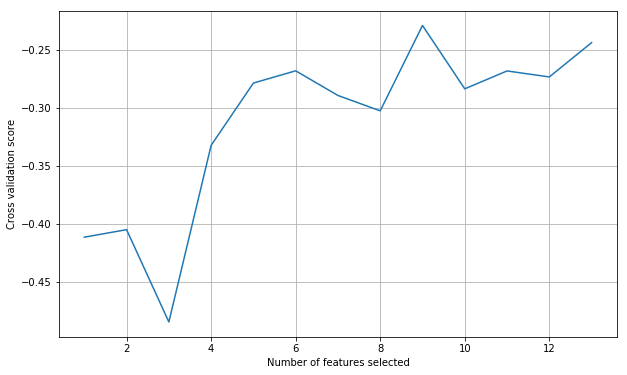

In [145]:
from sklearn.feature_selection import RFECV

ETR = ExtraTreesRegressor(n_estimators=10, max_depth=100)
selector = RFECV(ETR, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)

print("Numero optimo de features : %d" % selector.n_features_)
print("Scores: ", selector.grid_scores_) # Puntaje de ajuste
print("Ranking: ", selector.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
plt.grid(True)
plt.show()

In [147]:
pos = np.argwhere(selector.support_).T[0]

[ 0  1  3  4  5  6  8  9 10]


In [149]:
XX_train_sc = X_train_sc.iloc[:, pos]
etr_mse = cross_val_score(ETR, XX_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
etr_mae = cross_val_score(ETR, XX_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
etr_r2 = cross_val_score(ETR, XX_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("XX")
print("MSE: ", etr_mse.mean())
print("MAE: ", etr_mae.mean())
print("R2: ", etr_r2.mean())

XX
MSE:  -2.52608416496
MAE:  -1.23455416513
R2:  -0.260237508721


In [199]:
from sklearn.decomposition import PCA

PCA = PCA(n_components=8)
XPCA = PCA.fit_transform(X_train_sc)

In [200]:
svr = SVR()
asd = cross_val_score(svr, XPCA, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.187641758446


In [185]:
from sklearn.decomposition import KernelPCA

KPCA = KernelPCA(n_components=10, kernel='rbf')
XKPCA = KPCA.fit_transform(X_train_sc)

In [186]:
mlp = MLPRegressor()
asd = cross_val_score(mlp, XKPCA, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0221904283831


In [217]:
svr = SVR()
asd = cross_val_score(svr, XPCA, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

(517,)

In [220]:
from sklearn.ensemble import BaggingRegressor

param_grid = {
    "n_estimators": [100, 200]
}

BR = BaggingRegressor(base_estimator=MLPRegressor())

# run grid search
grid_search_BR = GridSearchCV(BR, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = grid_search_BR.fit(X_train_sc, y_train_sc)
print("Best parameters: ", grid_search_BR.best_params_)

Best parameters:  {'n_estimators': 100}


In [221]:
CVScores(grid_search_BR)

,Metric,Score
0,Train R²:,0.170603
1,Train MSE:,-1.619212
2,Train MAE:,-1.030219
3,Test R²:,-0.068353
4,Test MSE:,-2.076392
5,Test MAE:,-1.157568


In [228]:
BE = ExtraTreesRegressor(n_estimators=100, max_depth=100, n_jobs=-1)
BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
asd = cross_val_score(BR, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0745248385971


In [238]:
#BE = ExtraTreesRegressor(n_jobs=-1)
BE = MLPRegressor(hidden_layer_sizes=(10, 5, 2))
BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
asd = cross_val_score(BR, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0226336569727


In [239]:
from sklearn.feature_selection import RFECV

#BE = ExtraTreesRegressor(n_estimators=100, max_depth=100, n_jobs=-1)
#BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
#RFR = RandomForestRegressor(max_depth=100, n_jobs=-1)
MLP = MLPRegressor(hidden_layer_sizes=(10, 5, 2))
selector = RFECV(MLP, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)

print("Numero optimo de features : %d" % selector.n_features_)
print("Scores: ", selector.grid_scores_) # Puntaje de ajuste
print("Ranking: ", selector.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
plt.grid(True)
plt.show()

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [243]:
mlp = MLPRegressor(
    activation='relu', 
    alpha=0.1, 
    batch_size=200, 
    hidden_layer_sizes=(20,), 
    learning_rate='adaptive', 
    solver='sgd'
)

BR = BaggingRegressor(base_estimator=mlp, n_estimators=100, n_jobs=-1)
asd = cross_val_score(BR, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0033752193049


In [249]:
lr = LinearRegression(fit_intercept=False)
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
mlpr = MLPRegressor()
svr = SVR()

# Fit
_ = lr.fit(X_train_sc, y_train_sc)
_ = dtr.fit(X_train_sc, y_train_sc)
_ = rfr.fit(X_train_sc, y_train_sc)
_ = mlpr.fit(X_train_sc, y_train_sc)
_ = svr.fit(X_train_sc, y_train_sc)

In [250]:
# Predict
lrX = lr.predict(X_train_sc)
dtrX = dtr.predict(X_train_sc)
rfrX = rfr.predict(X_train_sc)
mlprX = mlpr.predict(X_train_sc)
svrX = svr.predict(X_train_sc)

In [259]:
new_X = np.array([lrX, dtrX, rfrX, mlprX, svrX]).T

In [261]:
lrb = LinearRegression()
_ = lrb.fit(new_X, y_train_sc)

In [262]:
y_pred = lrb.predict(new_X)
printScores(y_train_sc, y_pred)

R²:  0.992580209921
MSE:  0.0144822466749
RMSE:  0.12034220654
MAE:  0.0189657782804


In [275]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=10)
XPCA = pca.fit_transform(X_train_sc)

In [292]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=3, kernel='rbf')
XKPCA = kpca.fit_transform(X_train_sc)

In [306]:
from sklearn.model_selection import KFold

ns_ = 5
kf = KFold(n_splits=ns_)
#Xm = pd.get_dummies(X_train_sc, columns=['month', 'day']).as_matrix()
Xm = M_train_sc.as_matrix()
ym = y_train_sc.as_matrix()

train_score_cv = 0 
val_score_cv = 0 

for train, val in kf.split(Xm):   
    lr = LinearRegression(fit_intercept=False)
    dtr = DecisionTreeRegressor(max_depth=5)
    rfr = RandomForestRegressor(max_depth=5)
    mlpr = MLPRegressor(hidden_layer_sizes=(10,))
    svr = SVR(kernel='rbf', C=0.001)
    abr = AdaBoostRegressor(n_estimators=100)
    gbr = GradientBoostingRegressor(n_estimators=100)
    etr = ExtraTreesRegressor(n_estimators=100, max_depth=100, n_jobs=-1)

    # Fit
    _ = lr.fit(Xm[train], ym[train])
    _ = dtr.fit(Xm[train], ym[train])
    _ = rfr.fit(Xm[train], ym[train])
    _ = mlpr.fit(Xm[train], ym[train])
    _ = svr.fit(Xm[train], ym[train])
    _ = abr.fit(Xm[train], ym[train])
    _ = gbr.fit(Xm[train], ym[train])
    _ = etr.fit(Xm[train], ym[train])
    
    # Training data
    tr_lrX = lr.predict(Xm[train])
    tr_dtrX = dtr.predict(Xm[train])
    tr_rfrX = rfr.predict(Xm[train])
    tr_mlprX = mlpr.predict(Xm[train])
    tr_svrX = svr.predict(Xm[train])
    tr_abrX = abr.predict(Xm[train])
    tr_gbrX = gbr.predict(Xm[train])
    tr_etrX = etr.predict(Xm[train])
    
    # Validation data
    val_lrX = lr.predict(Xm[val])
    val_dtrX = dtr.predict(Xm[val])
    val_rfrX = rfr.predict(Xm[val])
    val_mlprX = mlpr.predict(Xm[val])
    val_svrX = svr.predict(Xm[val])
    val_abrX = abr.predict(Xm[val])
    val_gbrX = gbr.predict(Xm[val])
    val_etrX = etr.predict(Xm[val])

    trX = np.array([tr_lrX, tr_dtrX, tr_rfrX, tr_mlprX, tr_svrX, tr_abrX, tr_gbrX, tr_etrX]).T
    valX = np.array([val_lrX, val_dtrX, val_rfrX, val_mlprX, val_svrX, val_abrX, val_gbrX, val_etrX]).T
    
    newScaler = StandardScaler()
    trX_sc = newScaler.fit_transform(trX)
    valX_sc = newScaler.transform(valX)
    
    lrb = LinearRegression()
    _ = lrb.fit(trX_sc, ym[train])
    
    train_score_cv += lrb.score(trX_sc, ym[train])
    y_pred = lrb.predict(valX_sc)
    val_score_cv += r2_score(ym[val], y_pred)
    
    
train_score = train_score_cv / ns_
val_score = val_score_cv / ns_
print("Train score: %.4f, Validation Score: %.4f" % (train_score, val_score))

Train score: 0.9518, Validation Score: -0.2594


In [334]:
mlpp = MLPRegressor(hidden_layer_sizes=(1000, 1000, 1000), activation='relu', solver='sgd')
#BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
asd = cross_val_score(mlpp, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.00691269047702


In [330]:
mlpp.fit(X_train_sc, y_train_sc)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(400, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)